In [11]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt

def gauss(X, sigma, centre):
    return np.exp(-np.linalg.norm(X-centre)**2/(2*sigma**2))

class RBF():
    def __init__(self, num_clusters, sigma=None):
        self.num_clusters = num_clusters
        self.sigma = sigma
        self.wights = None
        self.clusters = None
    
    def compute(self, X):
        H = np.zeros((X.shape[0], self.num_clusters))
        for i in range(X.shape[0]):
            for j in range(self.num_clusters):
                H[i, j] = gauss(X[i], self.sigma, self.clusters[j])
        return H
    
    def fit(self, x, y):
        self.clusters = KMeans(n_clusters=self.num_clusters).fit(x).cluster_centers_

        if self.sigma is None:
            dist = []
            for i in range(self.num_clusters):
                for j in range(i+1, self.num_clusters):
                    dist.append(np.linalg.norm(self.clusters[i]-self.clusters[j]))
            self.sigma = np.mean(dist)

        H = self.compute(x)
        self.class_ = np.unique(y)
        T = np.zeros((x.shape[0], len(self.class_)))
        for i, label in enumerate(y):
            T[i, np.where(self.class_==label)[0][0]] = 1
        
        self.weights = np.linalg.pinv(H).dot(T)
    
    def predict(self, x):
        H = self.compute(x)
        pred = H.dot(self.weights)
        return self.class_[np.argmax(pred, axis=1)]
    


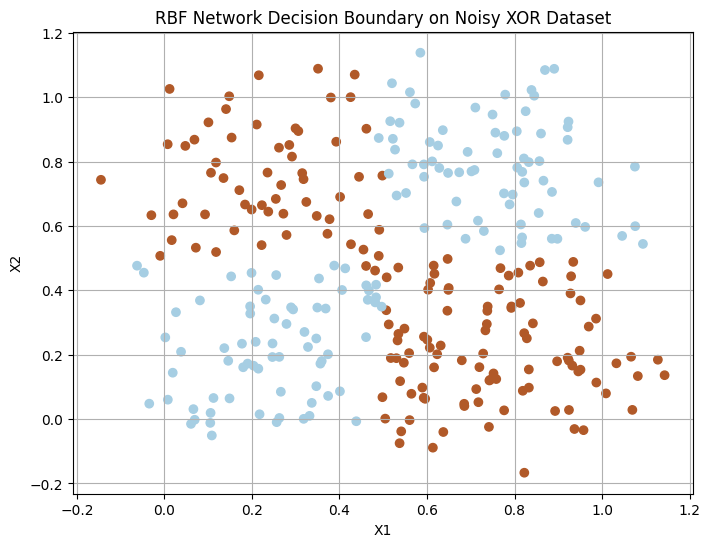

In [16]:
def generate_noisy_xor(n_samples=200, noise=0.1):
    X = np.random.rand(n_samples, 2)
    y = np.array([0 if (x[0] < 0.5 and x[1] < 0.5) or (x[0] >= 0.5 and x[1] >= 0.5) else 1
                  for x in X])
    X += noise * np.random.randn(n_samples, 2)
    return X, y

X_toy, y_toy = generate_noisy_xor(n_samples=300, noise=0.08)

# Train an RBF Network on the toy dataset:
num_centers = 10
rbf_net = RBF(num_clusters=num_centers)
rbf_net.fit(X_toy, y_toy)

# # Create a mesh grid for visualization:
plt.figure(figsize=(8, 6))

# Predict class labels for training points directly
preds = rbf_net.predict(X_toy)

# Scatter plot with color-coded predictions
plt.scatter(X_toy[:, 0], X_toy[:, 1], c=preds, cmap=plt.cm.Paired)

plt.title("RBF Network Decision Boundary on Noisy XOR Dataset")
plt.xlabel("X1")
plt.ylabel("X2")
plt.grid(True)
plt.show()


In [19]:
class_ = np.array([0, 1])   # Two unique classes
y = [0, 1, 1, 0]                 # Actual labels
for i in y:
    print(np.where(class_==i)[0][0])     # Index of the first label in class_

0
1
1
0


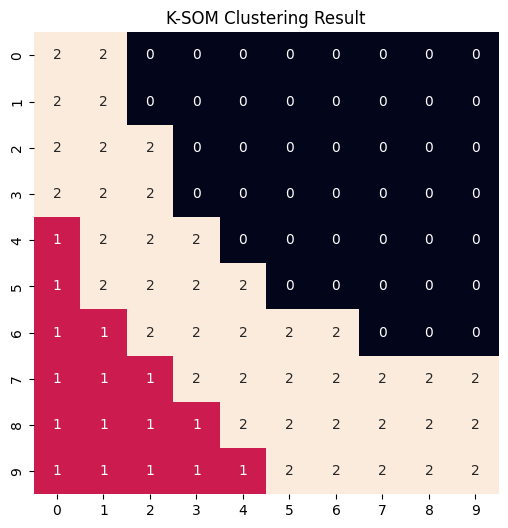

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# -------- Data Loading & Preprocessing --------
def load_data():
    iris = datasets.load_iris()
    data = iris.data
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

# -------- SOM Initialization --------
def init_grid(rows, cols, dim):
    return np.random.rand(rows, cols, dim)

# -------- Helper: Euclidean Distance --------
def euclidean(a, b):
    return np.linalg.norm(a - b)

# -------- Find Best Matching Unit (BMU) --------
def find_bmu(x, grid):
    rows, cols, _ = grid.shape
    min_dist = np.inf
    bmu_idx = (0, 0)
    for i in range(rows):
        for j in range(cols):
            d = euclidean(x, grid[i, j])
            if d < min_dist:
                min_dist, bmu_idx = d, (i, j)
    return bmu_idx

# -------- Update Grid Weights --------
def update_grid(x, bmu, grid, lr, sigma):
    rows, cols, _ = grid.shape
    for i in range(rows):
        for j in range(cols):
            grid_dist = np.sqrt((i - bmu[0])**2 + (j - bmu[1])**2)
            h = np.exp(- (grid_dist**2) / (2 * (sigma**2)))
            grid[i, j] += lr * h * (x - grid[i, j])
    return grid

# -------- Train the SOM --------
def train_som(data, grid, num_iter=100, lr0=0.1, sigma0=None):
    rows, cols, _ = grid.shape
    if sigma0 is None:
        sigma0 = max(rows, cols) / 2
    for t in range(num_iter):
        # lr = lr0 * (1 - t / num_iter)
        # sigma = sigma0 * (1 - t / num_iter)
        for x in data:
            bmu = find_bmu(x, grid)
            grid = update_grid(x, bmu, grid, lr0, sigma0)
    return grid

# -------- K-Means for K-SOM Clustering --------
def ksom_clustering(grid, k):
    flat_grid = grid.reshape(-1, grid.shape[2])
    kmeans = KMeans(n_clusters=k, random_state=42).fit(flat_grid)
    cluster_labels = kmeans.labels_.reshape(grid.shape[0], grid.shape[1])
    return cluster_labels

# -------- Plot Clustered SOM Grid --------
def plot_clustered_heatmap(cluster_labels):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cluster_labels, annot=True, cbar=False)
    plt.title("K-SOM Clustering Result")
    plt.show()

# -------- Main Function --------
def main():
    data = load_data()
    rows, cols = 10, 10  # SOM grid dimensions
    grid = init_grid(rows, cols, data.shape[1])
    grid = train_som(data, grid, num_iter=100, lr0=0.1)

    # Apply K-SOM clustering
    k = 3  # Number of clusters
    cluster_labels = ksom_clustering(grid, k)
    plot_clustered_heatmap(cluster_labels)

if __name__ == "__main__":
    main()


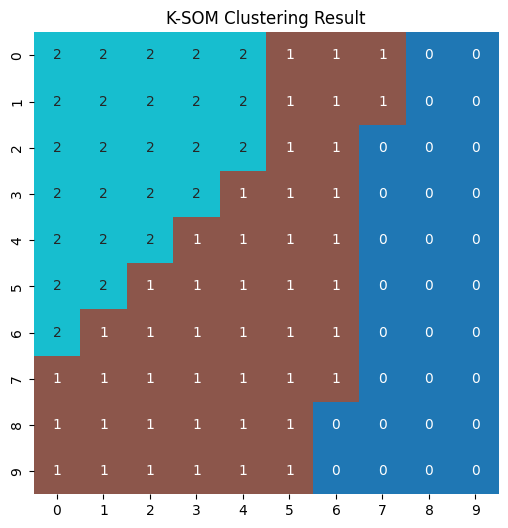

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

# -------- Data Loading & Preprocessing --------
def load_data():
    iris = datasets.load_iris()
    data = iris.data
    scaler = MinMaxScaler()
    return scaler.fit_transform(data)

# -------- SOM Initialization --------
def init_grid(rows, cols, dim):
    return np.random.rand(rows, cols, dim)

# -------- Helper: Euclidean Distance --------
def euclidean(a, b):
    return np.linalg.norm(a - b)

# -------- Find Best Matching Unit (BMU) --------
def find_bmu(x, grid):
    rows, cols, _ = grid.shape
    min_dist = np.inf
    bmu_idx = (0, 0)
    for i in range(rows):
        for j in range(cols):
            d = euclidean(x, grid[i, j])
            if d < min_dist:
                min_dist, bmu_idx = d, (i, j)
    return bmu_idx

# -------- Update Grid Weights --------
def update_grid(x, bmu, grid, lr, sigma):
    rows, cols, _ = grid.shape
    for i in range(rows):
        for j in range(cols):
            grid_dist = np.sqrt((i - bmu[0])**2 + (j - bmu[1])**2)
            h = np.exp(- (grid_dist**2) / (2 * (sigma**2)))
            grid[i, j] += lr * h * (x - grid[i, j])
    return grid

# -------- Train the SOM --------
def train_som(data, grid, num_iter=100, lr0=0.1, sigma0=None):
    rows, cols, _ = grid.shape
    if sigma0 is None:
        sigma0 = max(rows, cols) / 2
    for t in range(num_iter):
        lr = lr0 * (1 - t / num_iter)
        sigma = sigma0 * (1 - t / num_iter)
        for x in data:
            bmu = find_bmu(x, grid)
            grid = update_grid(x, bmu, grid, lr, sigma)
    return grid

# -------- K-Means for K-SOM Clustering --------
def ksom_clustering(grid, k):
    flat_grid = grid.reshape(-1, grid.shape[2])
    kmeans = KMeans(n_clusters=k, random_state=42).fit(flat_grid)
    cluster_labels = kmeans.labels_.reshape(grid.shape[0], grid.shape[1])
    return cluster_labels

# -------- Plot Clustered SOM Grid --------
def plot_clustered_heatmap(cluster_labels):
    plt.figure(figsize=(6, 6))
    sns.heatmap(cluster_labels, cmap="tab10", annot=True, cbar=False)
    plt.title("K-SOM Clustering Result")
    plt.show()

# -------- Main Function --------
def main():
    data = load_data()
    rows, cols = 10, 10  # SOM grid dimensions
    grid = init_grid(rows, cols, data.shape[1])
    grid = train_som(data, grid, num_iter=100, lr0=0.1)

    # Apply K-SOM clustering
    k = 3  # Number of clusters
    cluster_labels = ksom_clustering(grid, k)
    plot_clustered_heatmap(cluster_labels)

if __name__ == "__main__":
    main()
